## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Our notebook is organised as so, and we try to have a look at the data before jumping into model selection.

Introduction EDA
Look at top Station
Temporal Analysis:
- Seasonal look (Overview)
- Rush Hours
- Weekdays and Week-ends
- Bank Holidays vs working days
- School Holidays (vacances scolaires) and working days

The idea of using Ridge was to use a model where less important parameters are squished to see which parameters are really important, we then are going to use them with a RandomForest. Why a RF will be explained later in this notebook.
Model Selection:
- Trying out a simple Ridge regression with feature engineering on temporal data (hours_cos is a good predictor)
- Gridsearch and Hyperparameters selection for Ridge
- Adding weather data
- Ridge Limitations
- Trying out RandomForest

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

## Exploratory Data Analysis

In [28]:
# Standard Libraries
from pathlib import Path
import datetime

# Data Manipulation
import numpy as np
import pandas as pd


# Scikit-Learn: Preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PolynomialFeatures,
    LabelEncoder,
    FunctionTransformer
)

# Scikit-Learn: Pipelines and Transformations
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Scikit-Learn: Model Selection
from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV,
    train_test_split
)

# Scikit-Learn: Metrics
from sklearn.metrics import mean_squared_error

# Scikit-Learn: Regressors
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Optimization Libraries
import optuna

In [29]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [7]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [8]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [9]:
(
    df.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_11616\2792127300.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


In [10]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

In [ ]:
# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

In [ ]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [13]:
# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

Velib are used for commuting to working  looking at the peak hours. Let's verify that by looking at weekdays/weekends and weekdays/holidays patterns an important difference will indicate different use.

In [14]:
# Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

In [15]:
holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.dtypes

date    datetime64[ns]
dtype: object

In [16]:
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

In [17]:
# Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

The difference is even more important than with weekdays vs weekends.

In [18]:
# Read the holidays data
holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')
holidays_sco.head()

,date
0,2017-10-20
1,2017-10-21
2,2017-10-22
3,2017-10-23
4,2017-10-24


In [19]:
holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

In [20]:
holidays_sco = holidays_sco[holidays_sco['date'].dt.year == 2021]
holidays_sco = holidays_sco.drop_duplicates()
len(holidays_sco)

133

In [21]:
# 2. Compare traffic patterns vacances scolaires vs not vacances scolaires
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday_sco'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays (Scolaire) vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays (scolaire)'])
plt.grid(True)
plt.show()

NameError: name 'plt' is not defined

The impact is less pronounced for holidays_sco than for bank holidays, indeed french childrens have quite a lot of holiday and adults don't always take their holidays at the same time (and have less). The information still seems to hold value so we will use it in our models.

We are considering using Cosine transformation to my data to better capture cyclical patterns. This is the analysis obtained (I decided not too keep the code because we will be dropping the use of most of these features)

We tried this encoding and checked its correlation with log_bikes

 Add cyclical encoding for hour (24-hour cycle)
- df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
- df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

 Add cyclical encoding for month (12-month cycle)
- df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
- df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

Add cyclical encoding for day_of_week (7-day cycle)
- df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
- df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

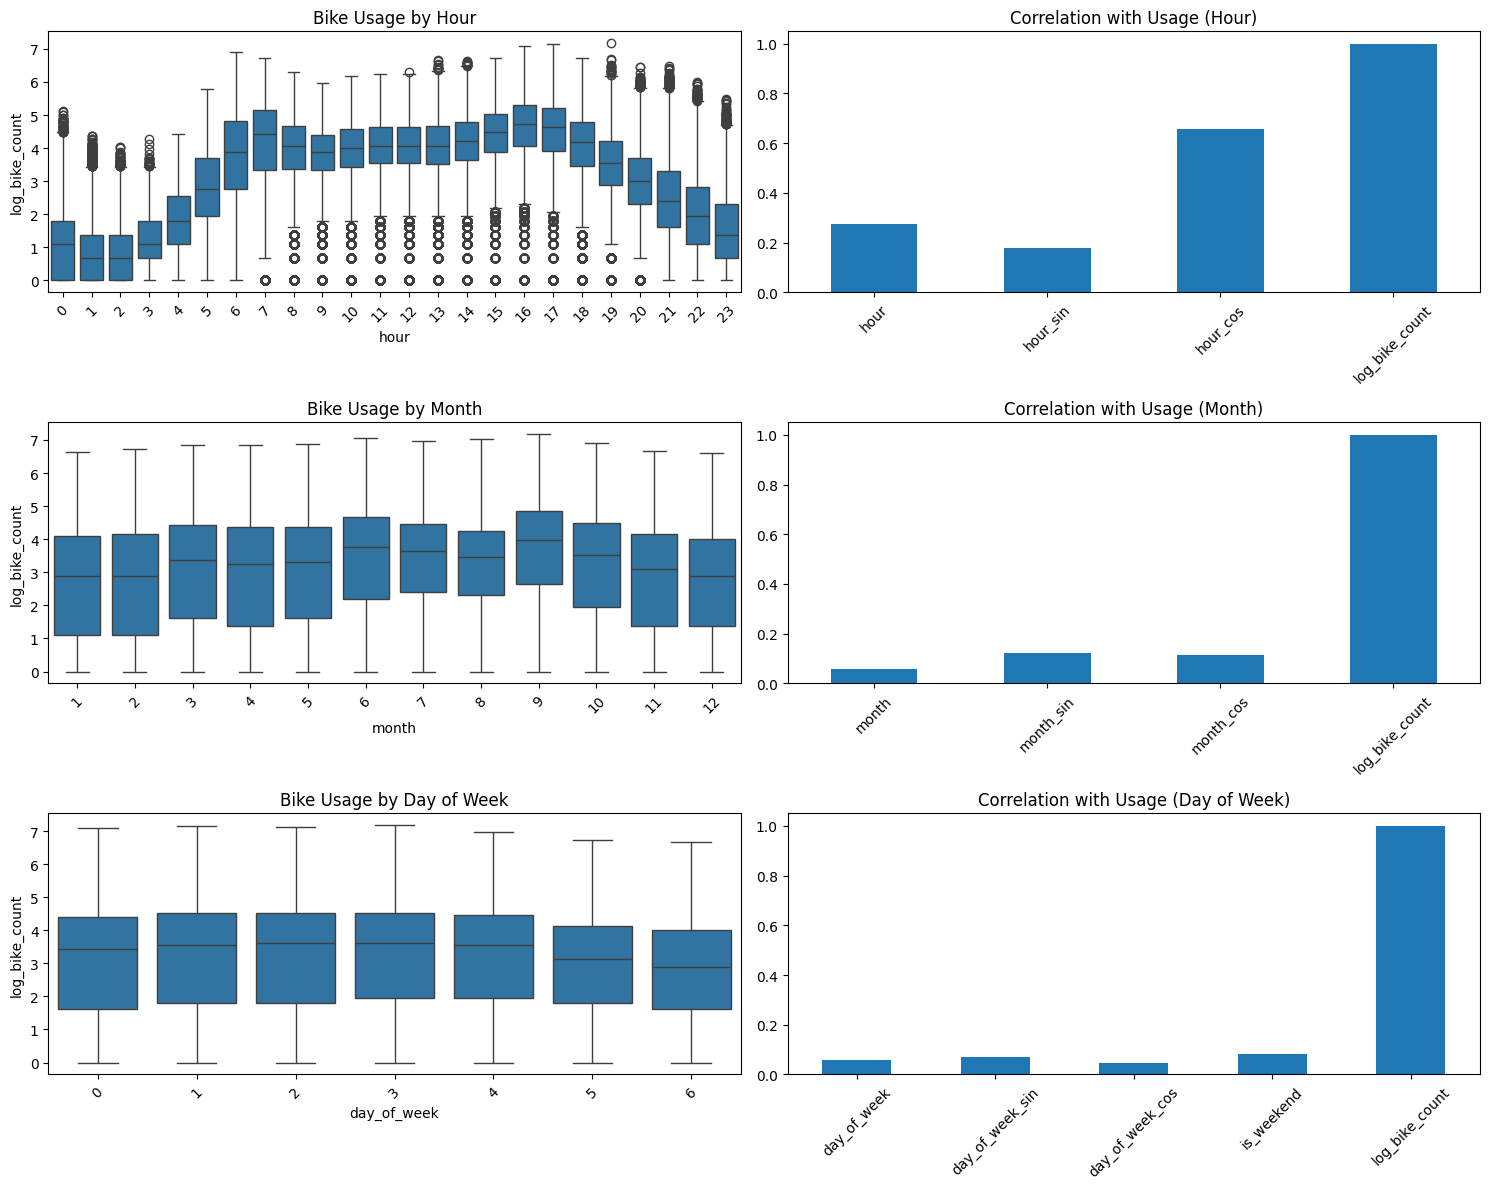

1. Let's keep:
- For the hour, let's replace the raw hour by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For themonth, let's replace the raw month by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For the day of the week, let's keep the raw data to avoid feature inflation

In [23]:
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,hour,day_of_week,month,weekday,is_weekend,is_holiday,is_holiday_sco
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2,1,9,Tuesday,False,False,False
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,3,1,9,Tuesday,False,False,False
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,4,1,9,Tuesday,False,False,False
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,15,1,9,Tuesday,False,False,False
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,18,1,9,Tuesday,False,False,False


In [31]:
df['date'] = pd.to_datetime(df['date']).dt.floor('h')


weather_df = pd.read_csv('external_data/Weather/Propre_meteo.csv')
covid_df = pd.read_csv('external_data/Covid/Propre_nbr_Covid.csv')

weather_df['date'] = pd.to_datetime(weather_df['date']).dt.floor('h')
covid_df['date'] = pd.to_datetime(covid_df['date']).dt.floor('h')

df = pd.merge(df, weather_df, on='date', how='left')
df = pd.merge(df, covid_df, on='date', how='left')

df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,Précipitations horaires,Petite_pluie,Grosse_pluie,index_ressenti,new_covid,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,12.75,81.0,30000.0,1.6,0.0,False,False,15.47,4982.0,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,10.95,88.0,25000.0,1.1,0.0,False,False,15.22,4982.0,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,10.95,88.0,25000.0,1.1,0.0,False,False,15.22,4982.0,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,20.65,41.0,30000.0,4.0,0.0,False,False,14.65,4982.0,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,19.15,47.0,30000.0,3.0,0.0,False,False,14.65,4982.0,18


In [25]:
df.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'Température de l'air', 'Humidité relative', 'Visibilité horizontale',
       'Vitesse du vent', 'Précipitations horaires', 'Petite_pluie',
       'Grosse_pluie', 'index_ressenti', 'new_covid', 'hour'],
      dtype='object')

In [32]:
def create_engineered_features(df):
    """Create optimized feature set based on correlation analysis"""
    df = df.copy()

    #Import holidays data
    holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
    holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

    #Define holidays columns and holidays_sco
    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)
    holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
    df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5

    # Keep only hour cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Create working day feature
    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])
    # Create rush hour feature (only for working days)
    morning_rush = (df['hour'].between(7, 9)) & df['is_working_day']
    evening_rush = (df['hour'].between(16, 18)) & df['is_working_day']
    # Add rush hour binary feature
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(bool)

    # Drop useless columns
    df = df.drop(columns='hour')
    df = df.drop(columns='month')
    df = df.drop(columns=['counter_id', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id'])


    # Define feature groups
    numeric_features = [
        'latitude',
        'longitude',
        'hour_sin',
        'hour_cos',
        'month_sin',
        'month_cos',
        "Température de l'air",
        'Humidité relative', 
        'Visibilité horizontale',
        'Vitesse du vent', 
        'Précipitations horaires',
        'index_ressenti', 
        'new_covid'
    ]

    binary_features = [
        'is_weekend',
        'is_holiday',
        'is_holiday_sco',
        'is_working_day',
        'is_rush_hour',
        'Petite_pluie',
        'Grosse_pluie'
    ]

    categorical_features = ['counter_name', 'weekday']

    target = ['log_bike_count']

    reordered_columns = numeric_features + binary_features + categorical_features + target
    df = df.reindex(columns=reordered_columns)


    return df, numeric_features, binary_features, categorical_features

In [33]:
final_df, numeric_features, binary_features, categorical_features = create_engineered_features(df)
final_df.head()

,latitude,longitude,hour_sin,hour_cos,month_sin,month_cos,Température de l'air,Humidité relative,Visibilité horizontale,Vitesse du vent,...,is_weekend,is_holiday,is_holiday_sco,is_working_day,is_rush_hour,Petite_pluie,Grosse_pluie,counter_name,weekday,log_bike_count
0,48.846028,2.375429,0.500000,8.660254e-01,-1.0,-1.836970e-16,12.75,81.0,30000.0,1.6,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.000000
1,48.846028,2.375429,0.707107,7.071068e-01,-1.0,-1.836970e-16,10.95,88.0,25000.0,1.1,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.693147
2,48.846028,2.375429,0.866025,5.000000e-01,-1.0,-1.836970e-16,10.95,88.0,25000.0,1.1,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,0.000000
3,48.846028,2.375429,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,20.65,41.0,30000.0,4.0,...,False,False,False,True,False,False,False,28 boulevard Diderot E-O,Tuesday,1.609438
4,48.846028,2.375429,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,19.15,47.0,30000.0,3.0,...,False,False,False,True,True,False,False,28 boulevard Diderot E-O,Tuesday,2.302585


In [1]:
correlation_matrix = final_df[final_numerical_features].corr()
# Créer la heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap de la matrice de corrélation')
plt.show()

NameError: name 'final_df' is not defined

In [26]:
def prepare_data(df, is_train=None):
    # Detect if training data by presence of log_bike_count
    if is_train is None:
        is_train = 'log_bike_count' in df.columns

    transformed_df, num_feat, bin_feat, cat_feat = create_engineered_features(df)

    if is_train:
        X = transformed_df.drop(columns=['log_bike_count'])
        y = transformed_df['log_bike_count']
        return X, y, num_feat, bin_feat, cat_feat
    else:
        return transformed_df, num_feat, bin_feat, cat_feat

In [27]:
def get_pipeline(numeric_features, binary_features, categorical_features):
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('bin', 'passthrough', binary_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ])

In [28]:
X, y, num_feat, bin_feat, cat_feat = prepare_data(df, is_train=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tscv = TimeSeriesSplit(n_splits=2, test_size=24*7)  # 1 week test size
pipeline = get_pipeline(num_feat, bin_feat, cat_feat)

grid_search = GridSearchCV(
    pipeline,
    {
        'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
        'regressor__fit_intercept': [True],
    },
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [42]:

grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.4f}")

results_df = pd.DataFrame(grid_search.cv_results_)
print("\nTop 5 parameter combinations:")
top_results = results_df.sort_values('mean_test_score', ascending=False).head()
for _, row in top_results.iterrows():
    print(f"\nScore: {-row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")
    print("Parameters:", {k.replace('regressor__', ''): v for k, v in row['params'].items()})

# Test score
test_score = grid_search.score(X_test, y_test)
print(f"\nTest set score: {-test_score:.4f}")

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best parameters: {'regressor__alpha': 100.0, 'regressor__fit_intercept': True}
Best score: 0.9366

Top 5 parameter combinations:

Score: 0.9366 (+/- 0.0258)
Parameters: {'alpha': 100.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0255)
Parameters: {'alpha': 10.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 1.0, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 0.1, 'fit_intercept': True}

Score: 0.9368 (+/- 0.0254)
Parameters: {'alpha': 0.01, 'fit_intercept': True}

Test set score: 0.8968


RMSE of Ridge is quite high with this pipeline.

In [ ]:
X = final_df[numeric_features + categorical_features + binary_features]
y = final_df['log_bike_count']

class BikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
            'month_sin',
            'month_cos'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco',
            'is_working_day',
            'is_rush_hour'
        ]

        self.categorical_features = [
            'counter_name',
            'weekday'
        ]

    def create_pipeline(self):
        # Add polynomial features for numeric variables
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ])

    def grid_search(self, X, y):
        # Expanded parameter grid
        param_grid = {
            'regressor__alpha': [1.0, 10.0, 100.0],
            'preprocessor__num__poly__degree': [1, 2]  # Try with and without polynomial features
        }

        # Time series split with more folds
        tscv = TimeSeriesSplit(n_splits=5, gap=24)  # gap of 24 hours

        # Create grid search
        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X, y)

        return grid_search

    def analyze_errors(self, model, X, y):
        """Analyze prediction errors to understand model weaknesses"""
        y_pred = model.predict(X)
        errors = y - y_pred

        error_analysis = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': X['hour'] if 'hour' in X.columns else None,
            'is_weekend': X['is_weekend'] if 'is_weekend' in X.columns else None
        })

        # Aggregate errors by different conditions
        analysis = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': error_analysis[error_analysis['is_weekend']]['abs_error'].mean(),
            'weekday_rmse': error_analysis[~error_analysis['is_weekend']]['abs_error'].mean(),
        }

        return analysis, error_analysis

predictor = BikePredictor()

# Perform grid search
grid_search = predictor.grid_search(X, y)

# Get best model
best_model = grid_search.best_estimator_

# Analyze errors
error_analysis, error_df = predictor.analyze_errors(best_model, X, y)

print("\nError Analysis:")
for metric, value in error_analysis.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Error Analysis:
overall_rmse: 0.7904
weekend_rmse: 0.6087
weekday_rmse: 0.5717


In [49]:
grid_search.best_params_

{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0}

Looking at these error analysis results, let's interpret and make improvements:

The overall RMSE has improved to 0.7904 (better than previous 1.1585)
Weekend errors (0.6236) are slightly higher than weekday errors (0.5717)


From "Forecasting Bike Rental Demand" by Du et al., they found that hourly patterns have "clear variation between work days and weekends" and "certain hours (peak hours) will clearly have significantly more bike rentals than other hours."
From "A predictive analytics approach for forecasting bike rental demand" (Karunanithi et al.), analysis showed distinct usage patterns:

Weekday peak hours: 7-9 am and 5-7 pm showed heavy usage (commuting patterns)
Weekend peak hours: 10 am - 6 pm showed different patterns
Total rentals during peak hours comprised 28.19% of all rentals

The main arguments for separate models are:
Different Behaviors:
Peak hours are dominated by commuter patterns
Off-peak hours follow leisure/tourism patterns
Different features might be important at different times

In [ ]:
def preprocess_data(X_train, X_test):
    """
    Preprocess the data by encoding categorical variables.

    Args:
        X_train: Training features
        X_test: Test features

    Returns:
        Preprocessed X_train and X_test
    """
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()

    # Identify categorical columns (object dtype)
    categorical_columns = X_train.select_dtypes(include=['object']).columns

    # Encode each categorical column
    for col in categorical_columns:
        le = LabelEncoder()
        # Fit on training data
        X_train_processed[col] = le.fit_transform(X_train[col])
        # Transform test data
        X_test_processed[col] = le.transform(X_test[col])

    return X_train_processed, X_test_processed

def objective(trial, X_train, X_test, y_train, y_test):
    """
    Objective function for Optuna optimization of LightGBM hyperparameters.

    Args:
        trial: Optuna trial object
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels

    Returns:
        float: RMSE score on test set
    """
    # Preprocess the data
    X_train_processed, X_test_processed = preprocess_data(X_train, X_test)

    # Define the hyperparameters to tune
    param_grid = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
    }

    # Create LightGBM datasets
    dtrain = lgb.Dataset(X_train_processed, label=y_train)
    dtest = lgb.Dataset(X_test_processed, label=y_test, reference=dtrain)

    # Create early stopping callback
    early_stopping_callback = lgb.early_stopping(stopping_rounds=50, verbose=False)

    # Train model
    gbm = lgb.train(
        param_grid,
        dtrain,
        valid_sets=[dtrain, dtest],
        valid_names=['train', 'test'],
        num_boost_round=1000,
        callbacks=[early_stopping_callback]
    )

    # Predict and calculate RMSE
    preds = gbm.predict(X_test_processed)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

def optimize_lightgbm(X_train, X_test, y_train, y_test, n_trials=100):
    """
    Run Optuna optimization for LightGBM hyperparameters.

    Args:
        X_train: Training features
        X_test: Test features
        y_train: Training labels
        y_test: Test labels
        n_trials: Number of optimization trials

    Returns:
        dict: Best hyperparameters found
    """
    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: objective(trial, X_train, X_test, y_train, y_test),
        n_trials=n_trials,
        show_progress_bar=True
    )

    print(f'Best RMSE: {study.best_value:.4f}')
    return study.best_params

In [31]:
best_params = optimize_lightgbm(X_train, X_test, y_train, y_test, n_trials=100)

[I 2024-12-03 20:30:17,526] A new study created in memory with name: no-name-11cb9f19-3639-4f56-aa99-c4ec62b5d921
  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   1%|          | 1/100 [00:22<37:31, 22.75s/it]

[I 2024-12-03 20:30:40,272] Trial 0 finished with value: 0.43368983888590557 and parameters: {'lambda_l1': 0.005265298316820153, 'lambda_l2': 0.0011282851180440389, 'num_leaves': 242, 'feature_fraction': 0.8446464992099486, 'bagging_fraction': 0.6921570904502305, 'bagging_freq': 7, 'min_child_samples': 97, 'learning_rate': 0.058860810970939224}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   2%|▏         | 2/100 [00:57<48:49, 29.89s/it]

[I 2024-12-03 20:31:15,167] Trial 1 finished with value: 1.5219237078332473 and parameters: {'lambda_l1': 0.0074964118956614405, 'lambda_l2': 3.1601976403079144e-06, 'num_leaves': 44, 'feature_fraction': 0.6346390529293036, 'bagging_fraction': 0.8772229100930864, 'bagging_freq': 2, 'min_child_samples': 23, 'learning_rate': 0.00014191978887931683}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   3%|▎         | 3/100 [01:40<58:12, 36.01s/it]

[I 2024-12-03 20:31:58,442] Trial 2 finished with value: 1.4060453330926281 and parameters: {'lambda_l1': 1.576386529254657e-07, 'lambda_l2': 1.5561097476858938, 'num_leaves': 90, 'feature_fraction': 0.814774207115206, 'bagging_fraction': 0.8394640496683374, 'bagging_freq': 6, 'min_child_samples': 53, 'learning_rate': 0.00022451322189024896}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   4%|▍         | 4/100 [02:05<50:35, 31.62s/it]

[I 2024-12-03 20:32:23,349] Trial 3 finished with value: 1.5257127343721855 and parameters: {'lambda_l1': 3.1105832145733236e-08, 'lambda_l2': 3.096172850612074e-06, 'num_leaves': 26, 'feature_fraction': 0.8502524577616541, 'bagging_fraction': 0.44322290609678255, 'bagging_freq': 5, 'min_child_samples': 36, 'learning_rate': 0.00012695761066298085}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   5%|▌         | 5/100 [02:22<41:40, 26.32s/it]

[I 2024-12-03 20:32:40,253] Trial 4 finished with value: 0.6159272594009649 and parameters: {'lambda_l1': 0.13093045798586644, 'lambda_l2': 0.005646819691831382, 'num_leaves': 13, 'feature_fraction': 0.8218804771966873, 'bagging_fraction': 0.6990793788811933, 'bagging_freq': 1, 'min_child_samples': 94, 'learning_rate': 0.0047277902488828665}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   6%|▌         | 6/100 [03:03<48:50, 31.18s/it]

[I 2024-12-03 20:33:20,859] Trial 5 finished with value: 0.4617016325407845 and parameters: {'lambda_l1': 5.103689174294535e-07, 'lambda_l2': 3.1262876235599245e-06, 'num_leaves': 99, 'feature_fraction': 0.4331956933467836, 'bagging_fraction': 0.8170401278625008, 'bagging_freq': 5, 'min_child_samples': 61, 'learning_rate': 0.012520836963637526}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   7%|▋         | 7/100 [03:41<51:39, 33.33s/it]

[I 2024-12-03 20:33:58,621] Trial 6 finished with value: 1.386621283759516 and parameters: {'lambda_l1': 0.009060364862938024, 'lambda_l2': 1.3173562631861717, 'num_leaves': 51, 'feature_fraction': 0.6596824171964337, 'bagging_fraction': 0.6828228045674787, 'bagging_freq': 6, 'min_child_samples': 98, 'learning_rate': 0.000279599528294757}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   8%|▊         | 8/100 [03:58<43:14, 28.20s/it]

[I 2024-12-03 20:34:15,845] Trial 7 finished with value: 0.5036343823341553 and parameters: {'lambda_l1': 8.161206026160012e-05, 'lambda_l2': 0.0008270449265575928, 'num_leaves': 12, 'feature_fraction': 0.8396768420331562, 'bagging_fraction': 0.8395827438142707, 'bagging_freq': 5, 'min_child_samples': 44, 'learning_rate': 0.02208492421831689}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:   9%|▉         | 9/100 [04:45<51:49, 34.17s/it]

[I 2024-12-03 20:35:03,138] Trial 8 finished with value: 0.6416457456118456 and parameters: {'lambda_l1': 0.3276282226235099, 'lambda_l2': 3.031250905746882e-07, 'num_leaves': 116, 'feature_fraction': 0.962327814140151, 'bagging_fraction': 0.6505522223690803, 'bagging_freq': 4, 'min_child_samples': 53, 'learning_rate': 0.0017687948860687773}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:  10%|█         | 10/100 [05:53<1:07:04, 44.72s/it]

[I 2024-12-03 20:36:11,478] Trial 9 finished with value: 0.46449031529015844 and parameters: {'lambda_l1': 0.15548211820611285, 'lambda_l2': 0.0020058294904076444, 'num_leaves': 232, 'feature_fraction': 0.9077538416909362, 'bagging_fraction': 0.9460986933899642, 'bagging_freq': 2, 'min_child_samples': 85, 'learning_rate': 0.0044887850752913325}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:  11%|█         | 11/100 [06:27<1:01:10, 41.25s/it]

[I 2024-12-03 20:36:44,815] Trial 10 finished with value: 0.4339987974625816 and parameters: {'lambda_l1': 0.00017675216398528124, 'lambda_l2': 0.060813649786376066, 'num_leaves': 254, 'feature_fraction': 0.5381294400813006, 'bagging_fraction': 0.5410681492457201, 'bagging_freq': 7, 'min_child_samples': 75, 'learning_rate': 0.06554915221201875}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:  12%|█▏        | 12/100 [07:04<58:40, 40.01s/it]  

[I 2024-12-03 20:37:22,021] Trial 11 finished with value: 0.4348637839400917 and parameters: {'lambda_l1': 3.728139087406782e-05, 'lambda_l2': 0.048874945845145484, 'num_leaves': 251, 'feature_fraction': 0.5072103292421631, 'bagging_fraction': 0.5048069248538637, 'bagging_freq': 7, 'min_child_samples': 75, 'learning_rate': 0.09578256969796393}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 0. Best value: 0.43369:  13%|█▎        | 13/100 [07:38<55:22, 38.19s/it]

[I 2024-12-03 20:37:56,035] Trial 12 finished with value: 0.43445953114773145 and parameters: {'lambda_l1': 0.0017569883247990639, 'lambda_l2': 0.04575070960758298, 'num_leaves': 193, 'feature_fraction': 0.5630850748696625, 'bagging_fraction': 0.5722023179285928, 'bagging_freq': 7, 'min_child_samples': 73, 'learning_rate': 0.09235139970274539}. Best is trial 0 with value: 0.43368983888590557.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  14%|█▍        | 14/100 [08:31<1:01:19, 42.78s/it]

[I 2024-12-03 20:38:49,426] Trial 13 finished with value: 0.4332187593099914 and parameters: {'lambda_l1': 7.276458467815136e-06, 'lambda_l2': 4.9256813240094025e-05, 'num_leaves': 182, 'feature_fraction': 0.7600411685460214, 'bagging_fraction': 0.5616195046889224, 'bagging_freq': 7, 'min_child_samples': 78, 'learning_rate': 0.03634375154690226}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  15%|█▌        | 15/100 [09:32<1:08:13, 48.16s/it]

[I 2024-12-03 20:39:50,057] Trial 14 finished with value: 0.43708960093150373 and parameters: {'lambda_l1': 3.815378370617893e-06, 'lambda_l2': 5.1654075859966174e-05, 'num_leaves': 175, 'feature_fraction': 0.7294976962981667, 'bagging_fraction': 0.5984393183711786, 'bagging_freq': 4, 'min_child_samples': 5, 'learning_rate': 0.023027848746028732}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  16%|█▌        | 16/100 [10:38<1:14:50, 53.46s/it]

[I 2024-12-03 20:40:55,804] Trial 15 finished with value: 0.8126423766027833 and parameters: {'lambda_l1': 7.883531804321795, 'lambda_l2': 0.00011040281650768058, 'num_leaves': 165, 'feature_fraction': 0.722847727547923, 'bagging_fraction': 0.7791964422305903, 'bagging_freq': 6, 'min_child_samples': 87, 'learning_rate': 0.0012224599381532196}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  17%|█▋        | 17/100 [11:27<1:12:12, 52.20s/it]

[I 2024-12-03 20:41:45,067] Trial 16 finished with value: 0.4377462049168587 and parameters: {'lambda_l1': 4.272032552702907e-06, 'lambda_l2': 4.7818575735056766e-08, 'num_leaves': 202, 'feature_fraction': 0.9898966271865637, 'bagging_fraction': 0.4055703311294929, 'bagging_freq': 3, 'min_child_samples': 68, 'learning_rate': 0.0349957560000187}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  18%|█▊        | 18/100 [12:37<1:18:27, 57.41s/it]

[I 2024-12-03 20:42:54,617] Trial 17 finished with value: 0.44821438752084447 and parameters: {'lambda_l1': 8.072473501598177e-06, 'lambda_l2': 4.358572088280102e-05, 'num_leaves': 153, 'feature_fraction': 0.768816095307957, 'bagging_fraction': 0.7685129740107519, 'bagging_freq': 7, 'min_child_samples': 86, 'learning_rate': 0.00815564450908988}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  19%|█▉        | 19/100 [13:32<1:16:45, 56.86s/it]

[I 2024-12-03 20:43:50,197] Trial 18 finished with value: 0.43442312788270016 and parameters: {'lambda_l1': 0.0011115004901587758, 'lambda_l2': 0.0002988751892676399, 'num_leaves': 210, 'feature_fraction': 0.9256493920071426, 'bagging_fraction': 0.6224285853860024, 'bagging_freq': 6, 'min_child_samples': 99, 'learning_rate': 0.04381546862227752}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  20%|██        | 20/100 [14:37<1:18:53, 59.17s/it]

[I 2024-12-03 20:44:54,753] Trial 19 finished with value: 0.44390141021824725 and parameters: {'lambda_l1': 1.336009981858833e-08, 'lambda_l2': 1.0611315185739252e-08, 'num_leaves': 134, 'feature_fraction': 0.6268428672457256, 'bagging_fraction': 0.741281238040518, 'bagging_freq': 5, 'min_child_samples': 86, 'learning_rate': 0.01343301496866992}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  21%|██        | 21/100 [15:56<1:25:57, 65.29s/it]

[I 2024-12-03 20:46:14,301] Trial 20 finished with value: 0.6416298336376342 and parameters: {'lambda_l1': 3.2578034243651474e-07, 'lambda_l2': 0.007461436329928871, 'num_leaves': 236, 'feature_fraction': 0.7716680685198586, 'bagging_fraction': 0.48343599205905197, 'bagging_freq': 7, 'min_child_samples': 64, 'learning_rate': 0.0017253605756482814}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 13. Best value: 0.433219:  22%|██▏       | 22/100 [17:04<1:25:54, 66.08s/it]

[I 2024-12-03 20:47:22,223] Trial 21 finished with value: 0.4378640994387379 and parameters: {'lambda_l1': 0.00016642251798328945, 'lambda_l2': 0.23264849592941003, 'num_leaves': 252, 'feature_fraction': 0.4111146060148848, 'bagging_fraction': 0.5487985023530703, 'bagging_freq': 7, 'min_child_samples': 77, 'learning_rate': 0.05152305338200132}. Best is trial 13 with value: 0.4332187593099914.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 22. Best value: 0.433183:  23%|██▎       | 23/100 [18:06<1:23:16, 64.89s/it]

[I 2024-12-03 20:48:24,353] Trial 22 finished with value: 0.4331832722910343 and parameters: {'lambda_l1': 0.0009619524601365684, 'lambda_l2': 6.2228670743041, 'num_leaves': 220, 'feature_fraction': 0.5573462148105975, 'bagging_fraction': 0.5433060684683494, 'bagging_freq': 6, 'min_child_samples': 80, 'learning_rate': 0.049410794882713695}. Best is trial 22 with value: 0.4331832722910343.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  24%|██▍       | 24/100 [19:10<1:21:39, 64.47s/it]

[I 2024-12-03 20:49:27,839] Trial 23 finished with value: 0.4326256210371237 and parameters: {'lambda_l1': 0.01769919970101937, 'lambda_l2': 3.4063520735972594, 'num_leaves': 211, 'feature_fraction': 0.6784935052244604, 'bagging_fraction': 0.6585675345494972, 'bagging_freq': 6, 'min_child_samples': 92, 'learning_rate': 0.029513006550501382}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  25%|██▌       | 25/100 [20:17<1:21:26, 65.15s/it]

[I 2024-12-03 20:50:34,568] Trial 24 finished with value: 0.4326886482842842 and parameters: {'lambda_l1': 0.03668259829394155, 'lambda_l2': 7.315193878384618, 'num_leaves': 216, 'feature_fraction': 0.6833212796385079, 'bagging_fraction': 0.6261625305878911, 'bagging_freq': 6, 'min_child_samples': 82, 'learning_rate': 0.03301524599716942}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  26%|██▌       | 26/100 [20:59<1:12:06, 58.46s/it]

[I 2024-12-03 20:51:17,436] Trial 25 finished with value: 0.43466329960788797 and parameters: {'lambda_l1': 0.032832948875391586, 'lambda_l2': 6.776448135188775, 'num_leaves': 216, 'feature_fraction': 0.5795287529383814, 'bagging_fraction': 0.6519495764363985, 'bagging_freq': 4, 'min_child_samples': 91, 'learning_rate': 0.020856851484484667}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  27%|██▋       | 27/100 [22:08<1:14:52, 61.54s/it]

[I 2024-12-03 20:52:26,163] Trial 26 finished with value: 0.44516182250819897 and parameters: {'lambda_l1': 2.5748594194043104, 'lambda_l2': 6.730062504657059, 'num_leaves': 220, 'feature_fraction': 0.6735663842859146, 'bagging_fraction': 0.4953302474925431, 'bagging_freq': 6, 'min_child_samples': 61, 'learning_rate': 0.009494197625895187}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  28%|██▊       | 28/100 [22:58<1:09:36, 58.01s/it]

[I 2024-12-03 20:53:15,930] Trial 27 finished with value: 1.135294803968205 and parameters: {'lambda_l1': 0.0009301498556168466, 'lambda_l2': 0.5845922811036055, 'num_leaves': 147, 'feature_fraction': 0.500700941683986, 'bagging_fraction': 0.6214175208265006, 'bagging_freq': 5, 'min_child_samples': 81, 'learning_rate': 0.0006651838839922174}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  29%|██▉       | 29/100 [24:00<1:10:06, 59.25s/it]

[I 2024-12-03 20:54:18,084] Trial 28 finished with value: 0.4598320640852508 and parameters: {'lambda_l1': 0.9928798610451379, 'lambda_l2': 6.1221038821463765, 'num_leaves': 192, 'feature_fraction': 0.6052387894390772, 'bagging_fraction': 0.742115701953507, 'bagging_freq': 6, 'min_child_samples': 70, 'learning_rate': 0.006672899925470049}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 23. Best value: 0.432626:  30%|███       | 30/100 [24:56<1:08:08, 58.41s/it]

[I 2024-12-03 20:55:14,516] Trial 29 finished with value: 0.44521850246777994 and parameters: {'lambda_l1': 0.015415873395104975, 'lambda_l2': 0.3656841519990025, 'num_leaves': 218, 'feature_fraction': 0.47004613192558464, 'bagging_fraction': 0.5983823061685358, 'bagging_freq': 3, 'min_child_samples': 100, 'learning_rate': 0.01550501981653376}. Best is trial 23 with value: 0.4326256210371237.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 30. Best value: 0.432474:  31%|███       | 31/100 [25:39<1:01:40, 53.63s/it]

[I 2024-12-03 20:55:56,996] Trial 30 finished with value: 0.43247388502390366 and parameters: {'lambda_l1': 0.054520273122240046, 'lambda_l2': 2.521077416825659, 'num_leaves': 230, 'feature_fraction': 0.6888075740798699, 'bagging_fraction': 0.6874907172741369, 'bagging_freq': 5, 'min_child_samples': 90, 'learning_rate': 0.027388967887848604}. Best is trial 30 with value: 0.43247388502390366.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 31. Best value: 0.432203:  32%|███▏      | 32/100 [26:33<1:00:50, 53.69s/it]

[I 2024-12-03 20:56:50,836] Trial 31 finished with value: 0.43220266242993216 and parameters: {'lambda_l1': 0.04670417388313966, 'lambda_l2': 1.881173721693936, 'num_leaves': 235, 'feature_fraction': 0.6886264973117903, 'bagging_fraction': 0.666400187578616, 'bagging_freq': 5, 'min_child_samples': 92, 'learning_rate': 0.02903200435479164}. Best is trial 31 with value: 0.43220266242993216.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  33%|███▎      | 33/100 [27:17<56:41, 50.77s/it]  

[I 2024-12-03 20:57:34,777] Trial 32 finished with value: 0.4320825365026583 and parameters: {'lambda_l1': 0.05523134078560298, 'lambda_l2': 1.4751508359216003, 'num_leaves': 238, 'feature_fraction': 0.6840908231716412, 'bagging_fraction': 0.6892618139137773, 'bagging_freq': 5, 'min_child_samples': 92, 'learning_rate': 0.028956873662222715}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  34%|███▍      | 34/100 [28:13<57:37, 52.39s/it]

[I 2024-12-03 20:58:30,964] Trial 33 finished with value: 0.4321071188190001 and parameters: {'lambda_l1': 0.07168677885278, 'lambda_l2': 1.5612031531142332, 'num_leaves': 237, 'feature_fraction': 0.7125943434301242, 'bagging_fraction': 0.7209265021247713, 'bagging_freq': 5, 'min_child_samples': 91, 'learning_rate': 0.025837435699229704}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  35%|███▌      | 35/100 [29:14<59:41, 55.09s/it]

[I 2024-12-03 20:59:32,360] Trial 34 finished with value: 0.4340620110337969 and parameters: {'lambda_l1': 0.5616617637066307, 'lambda_l2': 0.14257894964158402, 'num_leaves': 235, 'feature_fraction': 0.7188858935762308, 'bagging_fraction': 0.7263069516167797, 'bagging_freq': 5, 'min_child_samples': 92, 'learning_rate': 0.017272098383255805}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  36%|███▌      | 36/100 [29:48<51:47, 48.56s/it]

[I 2024-12-03 21:00:05,670] Trial 35 finished with value: 0.433494223573993 and parameters: {'lambda_l1': 0.0816689703749296, 'lambda_l2': 1.4266141943265933, 'num_leaves': 237, 'feature_fraction': 0.6410276084805501, 'bagging_fraction': 0.7053230786472295, 'bagging_freq': 4, 'min_child_samples': 34, 'learning_rate': 0.06513512843679876}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  37%|███▋      | 37/100 [31:10<1:01:39, 58.73s/it]

[I 2024-12-03 21:01:28,124] Trial 36 finished with value: 0.45109800417578383 and parameters: {'lambda_l1': 0.003895583243291151, 'lambda_l2': 0.012448298492370818, 'num_leaves': 190, 'feature_fraction': 0.796677511120007, 'bagging_fraction': 0.7952422949380259, 'bagging_freq': 4, 'min_child_samples': 94, 'learning_rate': 0.006693004892546279}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  38%|███▊      | 38/100 [32:10<1:01:09, 59.19s/it]

[I 2024-12-03 21:02:28,398] Trial 37 finished with value: 0.458550901200131 and parameters: {'lambda_l1': 1.7603124708708762, 'lambda_l2': 1.1210006176837222, 'num_leaves': 77, 'feature_fraction': 0.703353527030254, 'bagging_fraction': 0.9183099947463105, 'bagging_freq': 5, 'min_child_samples': 89, 'learning_rate': 0.010618159535103658}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  39%|███▉      | 39/100 [33:42<1:09:56, 68.80s/it]

[I 2024-12-03 21:03:59,609] Trial 38 finished with value: 0.5195511153517895 and parameters: {'lambda_l1': 0.07545516317356482, 'lambda_l2': 0.139362995538202, 'num_leaves': 244, 'feature_fraction': 0.6222392613483856, 'bagging_fraction': 0.6825650508282801, 'bagging_freq': 3, 'min_child_samples': 96, 'learning_rate': 0.00326889136596993}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  40%|████      | 40/100 [34:52<1:09:15, 69.26s/it]

[I 2024-12-03 21:05:09,950] Trial 39 finished with value: 0.4323970065329443 and parameters: {'lambda_l1': 0.2760900513944942, 'lambda_l2': 0.6959097429057777, 'num_leaves': 229, 'feature_fraction': 0.878903155954879, 'bagging_fraction': 0.8439400345648669, 'bagging_freq': 5, 'min_child_samples': 56, 'learning_rate': 0.026687738324828698}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 32. Best value: 0.432083:  41%|████      | 41/100 [36:15<1:12:06, 73.33s/it]

[I 2024-12-03 21:06:32,770] Trial 40 finished with value: 0.43281404330065376 and parameters: {'lambda_l1': 0.2757407249919207, 'lambda_l2': 0.025256927155253753, 'num_leaves': 256, 'feature_fraction': 0.8718077657509371, 'bagging_fraction': 0.8865552598499405, 'bagging_freq': 5, 'min_child_samples': 24, 'learning_rate': 0.016618366863737483}. Best is trial 32 with value: 0.4320825365026583.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 41. Best value: 0.431886:  42%|████▏     | 42/100 [37:17<1:07:34, 69.91s/it]

[I 2024-12-03 21:07:34,703] Trial 41 finished with value: 0.4318863439649663 and parameters: {'lambda_l1': 0.004478780700264969, 'lambda_l2': 0.8743609282650583, 'num_leaves': 226, 'feature_fraction': 0.7363166392345581, 'bagging_fraction': 0.8472690983505095, 'bagging_freq': 5, 'min_child_samples': 47, 'learning_rate': 0.026031279449009976}. Best is trial 41 with value: 0.4318863439649663.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 41. Best value: 0.431886:  43%|████▎     | 43/100 [37:46<54:49, 57.70s/it]  

[I 2024-12-03 21:08:03,926] Trial 42 finished with value: 0.4325288528122694 and parameters: {'lambda_l1': 0.007028845141961165, 'lambda_l2': 0.6580262574842711, 'num_leaves': 201, 'feature_fraction': 0.7469197854333857, 'bagging_fraction': 0.8589708645377998, 'bagging_freq': 5, 'min_child_samples': 50, 'learning_rate': 0.06901196158412934}. Best is trial 41 with value: 0.4318863439649663.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  44%|████▍     | 44/100 [39:04<59:28, 63.72s/it]

[I 2024-12-03 21:09:21,678] Trial 43 finished with value: 0.4316762633509232 and parameters: {'lambda_l1': 0.20133237828953557, 'lambda_l2': 0.3062135266320733, 'num_leaves': 229, 'feature_fraction': 0.798824573972278, 'bagging_fraction': 0.9893954836181951, 'bagging_freq': 4, 'min_child_samples': 41, 'learning_rate': 0.020616199622466854}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  45%|████▌     | 45/100 [40:17<1:01:04, 66.63s/it]

[I 2024-12-03 21:10:35,111] Trial 44 finished with value: 0.4338088751216545 and parameters: {'lambda_l1': 0.002953523441553568, 'lambda_l2': 0.12321437949740405, 'num_leaves': 246, 'feature_fraction': 0.7992789715691353, 'bagging_fraction': 0.9694653174880031, 'bagging_freq': 4, 'min_child_samples': 36, 'learning_rate': 0.012707512601315571}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  46%|████▌     | 46/100 [40:46<49:50, 55.38s/it]  

[I 2024-12-03 21:11:04,238] Trial 45 finished with value: 0.4318216352334583 and parameters: {'lambda_l1': 0.013187660080369623, 'lambda_l2': 0.0025799551149255965, 'num_leaves': 204, 'feature_fraction': 0.8088313156007509, 'bagging_fraction': 0.9898550262586726, 'bagging_freq': 4, 'min_child_samples': 41, 'learning_rate': 0.04220669300631671}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  47%|████▋     | 47/100 [41:16<42:12, 47.79s/it]

[I 2024-12-03 21:11:34,318] Trial 46 finished with value: 0.4320211775104175 and parameters: {'lambda_l1': 0.012579058703997628, 'lambda_l2': 0.0029547036988154633, 'num_leaves': 170, 'feature_fraction': 0.827398020337086, 'bagging_fraction': 0.9945208246916909, 'bagging_freq': 3, 'min_child_samples': 43, 'learning_rate': 0.04447633867317098}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  48%|████▊     | 48/100 [41:36<34:06, 39.35s/it]

[I 2024-12-03 21:11:53,976] Trial 47 finished with value: 0.43212082873910695 and parameters: {'lambda_l1': 0.008491406084685942, 'lambda_l2': 0.0015997778625695808, 'num_leaves': 163, 'feature_fraction': 0.8265502629031964, 'bagging_fraction': 0.9828714472293474, 'bagging_freq': 3, 'min_child_samples': 44, 'learning_rate': 0.0741280740863112}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 43. Best value: 0.431676:  49%|████▉     | 49/100 [42:33<38:01, 44.73s/it]

[I 2024-12-03 21:12:51,251] Trial 48 finished with value: 1.4200365560084338 and parameters: {'lambda_l1': 0.0005801531704787197, 'lambda_l2': 6.553723077949747e-06, 'num_leaves': 184, 'feature_fraction': 0.8525191915936626, 'bagging_fraction': 0.9362701127136855, 'bagging_freq': 2, 'min_child_samples': 42, 'learning_rate': 0.00020053836531395963}. Best is trial 43 with value: 0.4316762633509232.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  50%|█████     | 50/100 [42:59<32:32, 39.05s/it] 

[I 2024-12-03 21:13:17,034] Trial 49 finished with value: 0.4314102600898588 and parameters: {'lambda_l1': 0.014001547670291518, 'lambda_l2': 0.004628329796484631, 'num_leaves': 201, 'feature_fraction': 0.7922229795091268, 'bagging_fraction': 0.9956410919359229, 'bagging_freq': 1, 'min_child_samples': 29, 'learning_rate': 0.041358540093023886}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  51%|█████     | 51/100 [1:12:52<7:41:33, 565.17s/it]

[I 2024-12-03 21:43:09,817] Trial 50 finished with value: 0.4316439993508452 and parameters: {'lambda_l1': 0.01643729612390695, 'lambda_l2': 0.0005551537242971362, 'num_leaves': 168, 'feature_fraction': 0.7931021889591464, 'bagging_fraction': 0.9953156023301498, 'bagging_freq': 2, 'min_child_samples': 25, 'learning_rate': 0.04287167336872136}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  52%|█████▏    | 52/100 [1:13:18<5:22:51, 403.57s/it]

[I 2024-12-03 21:43:36,318] Trial 51 finished with value: 0.43162300179698354 and parameters: {'lambda_l1': 0.01581766401803589, 'lambda_l2': 0.003570572987485873, 'num_leaves': 177, 'feature_fraction': 0.7973724407561231, 'bagging_fraction': 0.990835700528006, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.043647754166352484}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  53%|█████▎    | 53/100 [1:13:31<3:44:15, 286.29s/it]

[I 2024-12-03 21:43:48,959] Trial 52 finished with value: 0.4328699871455147 and parameters: {'lambda_l1': 0.003291841045807166, 'lambda_l2': 0.000632218747936624, 'num_leaves': 200, 'feature_fraction': 0.794039739759933, 'bagging_fraction': 0.956111597633077, 'bagging_freq': 1, 'min_child_samples': 23, 'learning_rate': 0.08242781278297286}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  54%|█████▍    | 54/100 [1:14:05<2:41:26, 210.58s/it]

[I 2024-12-03 21:44:22,893] Trial 53 finished with value: 0.4320574025892199 and parameters: {'lambda_l1': 0.020800815719360582, 'lambda_l2': 0.0003858696539364762, 'num_leaves': 179, 'feature_fraction': 0.7772760319426769, 'bagging_fraction': 0.9121359015540019, 'bagging_freq': 1, 'min_child_samples': 28, 'learning_rate': 0.044673994624196994}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  55%|█████▌    | 55/100 [1:14:45<1:59:29, 159.32s/it]

[I 2024-12-03 21:45:02,594] Trial 54 finished with value: 0.43706269725607144 and parameters: {'lambda_l1': 0.00033799729665872594, 'lambda_l2': 0.002998474175256227, 'num_leaves': 115, 'feature_fraction': 0.753129543273671, 'bagging_fraction': 0.9985805965094946, 'bagging_freq': 1, 'min_child_samples': 16, 'learning_rate': 0.020073573457965385}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  56%|█████▌    | 56/100 [1:15:11<1:27:39, 119.54s/it]

[I 2024-12-03 21:45:29,316] Trial 55 finished with value: 0.43383000873112443 and parameters: {'lambda_l1': 0.0038972349850123263, 'lambda_l2': 0.01704023481902319, 'num_leaves': 150, 'feature_fraction': 0.8515892272326046, 'bagging_fraction': 0.8936729429941732, 'bagging_freq': 2, 'min_child_samples': 16, 'learning_rate': 0.05605747183444475}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  57%|█████▋    | 57/100 [1:15:40<1:06:06, 92.26s/it] 

[I 2024-12-03 21:45:57,916] Trial 56 finished with value: 0.43339602862912346 and parameters: {'lambda_l1': 0.17318309453956438, 'lambda_l2': 0.00016426107152106998, 'num_leaves': 160, 'feature_fraction': 0.8956726311788029, 'bagging_fraction': 0.9636865832935113, 'bagging_freq': 1, 'min_child_samples': 33, 'learning_rate': 0.0415597372705145}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  58%|█████▊    | 58/100 [1:15:53<48:03, 68.65s/it]  

[I 2024-12-03 21:46:11,485] Trial 57 finished with value: 0.4343390929624626 and parameters: {'lambda_l1': 0.0019114889195989678, 'lambda_l2': 2.2492114989426585e-05, 'num_leaves': 204, 'feature_fraction': 0.9333940442079811, 'bagging_fraction': 0.9379083059839788, 'bagging_freq': 2, 'min_child_samples': 28, 'learning_rate': 0.09328184197762332}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  59%|█████▉    | 59/100 [1:16:17<37:38, 55.08s/it]

[I 2024-12-03 21:46:34,891] Trial 58 finished with value: 0.4316843503840937 and parameters: {'lambda_l1': 0.009042113326554435, 'lambda_l2': 0.006266413790294372, 'num_leaves': 135, 'feature_fraction': 0.8059729126341695, 'bagging_fraction': 0.919955566708979, 'bagging_freq': 1, 'min_child_samples': 48, 'learning_rate': 0.05778581059975713}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  60%|██████    | 60/100 [1:16:39<30:12, 45.30s/it]

[I 2024-12-03 21:46:57,392] Trial 59 finished with value: 0.431867199231808 and parameters: {'lambda_l1': 0.5895761319547415, 'lambda_l2': 0.006485219707647644, 'num_leaves': 130, 'feature_fraction': 0.8021528757549705, 'bagging_fraction': 0.9772678664929154, 'bagging_freq': 1, 'min_child_samples': 39, 'learning_rate': 0.058998551918899356}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  61%|██████    | 61/100 [1:17:30<30:27, 46.87s/it]

[I 2024-12-03 21:47:47,918] Trial 60 finished with value: 0.43292168055483216 and parameters: {'lambda_l1': 5.875363020583231, 'lambda_l2': 0.0009974533505274028, 'num_leaves': 140, 'feature_fraction': 0.8151234779190357, 'bagging_fraction': 0.9178047971992727, 'bagging_freq': 2, 'min_child_samples': 16, 'learning_rate': 0.03689117335183979}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  62%|██████▏   | 62/100 [1:17:57<25:55, 40.95s/it]

[I 2024-12-03 21:48:15,043] Trial 61 finished with value: 0.4319574347751112 and parameters: {'lambda_l1': 0.5886311365052563, 'lambda_l2': 0.005879157535790079, 'num_leaves': 127, 'feature_fraction': 0.7866692432269483, 'bagging_fraction': 0.977356688769262, 'bagging_freq': 1, 'min_child_samples': 39, 'learning_rate': 0.05936397146032277}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  63%|██████▎   | 63/100 [1:18:25<22:46, 36.94s/it]

[I 2024-12-03 21:48:42,626] Trial 62 finished with value: 0.4330506676652713 and parameters: {'lambda_l1': 0.14601174735019481, 'lambda_l2': 0.003272119583751993, 'num_leaves': 95, 'feature_fraction': 0.8391361428215561, 'bagging_fraction': 0.9540271297131407, 'bagging_freq': 1, 'min_child_samples': 30, 'learning_rate': 0.05512571681186578}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  64%|██████▍   | 64/100 [1:18:52<20:28, 34.14s/it]

[I 2024-12-03 21:49:10,233] Trial 63 finished with value: 0.4332156497253254 and parameters: {'lambda_l1': 0.026205538843182198, 'lambda_l2': 0.03920390941713779, 'num_leaves': 115, 'feature_fraction': 0.8152568136523564, 'bagging_fraction': 0.9966747751406948, 'bagging_freq': 1, 'min_child_samples': 39, 'learning_rate': 0.03651760672231557}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  65%|██████▌   | 65/100 [1:19:20<18:43, 32.10s/it]

[I 2024-12-03 21:49:37,562] Trial 64 finished with value: 0.43310759908257823 and parameters: {'lambda_l1': 0.5998277125698708, 'lambda_l2': 0.01083499069833158, 'num_leaves': 81, 'feature_fraction': 0.76292962127757, 'bagging_fraction': 0.936673677478523, 'bagging_freq': 2, 'min_child_samples': 52, 'learning_rate': 0.0999369949975389}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  66%|██████▌   | 66/100 [1:20:00<19:34, 34.55s/it]

[I 2024-12-03 21:50:17,847] Trial 65 finished with value: 0.43245620060442386 and parameters: {'lambda_l1': 3.6310709871964013, 'lambda_l2': 0.0003682533445156818, 'num_leaves': 125, 'feature_fraction': 0.8553913202709847, 'bagging_fraction': 0.9719265934402086, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.07656396732096717}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  67%|██████▋   | 67/100 [1:20:30<18:12, 33.12s/it]

[I 2024-12-03 21:50:47,621] Trial 66 finished with value: 0.43219419765090594 and parameters: {'lambda_l1': 1.3154466899389228, 'lambda_l2': 0.0014249535487524257, 'num_leaves': 144, 'feature_fraction': 0.8781698803840498, 'bagging_fraction': 0.980560608056697, 'bagging_freq': 1, 'min_child_samples': 48, 'learning_rate': 0.04690176433582017}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  68%|██████▊   | 68/100 [1:21:08<18:29, 34.68s/it]

[I 2024-12-03 21:51:25,939] Trial 67 finished with value: 0.43407462512420103 and parameters: {'lambda_l1': 0.009635124356779073, 'lambda_l2': 0.000624730785451196, 'num_leaves': 171, 'feature_fraction': 0.804101725987991, 'bagging_fraction': 0.948536639871846, 'bagging_freq': 1, 'min_child_samples': 10, 'learning_rate': 0.019913081433253838}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  69%|██████▉   | 69/100 [1:21:45<18:19, 35.46s/it]

[I 2024-12-03 21:52:03,211] Trial 68 finished with value: 1.076856554223083 and parameters: {'lambda_l1': 0.0017132188854712615, 'lambda_l2': 0.00014855689339140368, 'num_leaves': 104, 'feature_fraction': 0.7779991306409948, 'bagging_fraction': 0.8953885820713332, 'bagging_freq': 1, 'min_child_samples': 56, 'learning_rate': 0.0006472826904580964}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  70%|███████   | 70/100 [1:22:20<17:36, 35.20s/it]

[I 2024-12-03 21:52:37,821] Trial 69 finished with value: 0.4322222878469856 and parameters: {'lambda_l1': 0.1134329114463632, 'lambda_l2': 0.005366082976739099, 'num_leaves': 185, 'feature_fraction': 0.7387282454708501, 'bagging_fraction': 0.8683471202117298, 'bagging_freq': 2, 'min_child_samples': 38, 'learning_rate': 0.03511029141980965}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  71%|███████   | 71/100 [1:22:36<14:14, 29.47s/it]

[I 2024-12-03 21:52:53,901] Trial 70 finished with value: 0.43298431318779523 and parameters: {'lambda_l1': 0.030561857037743532, 'lambda_l2': 0.0275740484028216, 'num_leaves': 156, 'feature_fraction': 0.8362250842250705, 'bagging_fraction': 0.9171933440046709, 'bagging_freq': 1, 'min_child_samples': 31, 'learning_rate': 0.0644282892319809}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 49. Best value: 0.43141:  72%|███████▏  | 72/100 [1:23:11<14:32, 31.17s/it]

[I 2024-12-03 21:53:29,028] Trial 71 finished with value: 0.43388565447497796 and parameters: {'lambda_l1': 0.005837160800524674, 'lambda_l2': 0.06924010830902308, 'num_leaves': 134, 'feature_fraction': 0.7419680805525055, 'bagging_fraction': 0.9980902823567886, 'bagging_freq': 4, 'min_child_samples': 47, 'learning_rate': 0.024899932859075644}. Best is trial 49 with value: 0.4314102600898588.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  73%|███████▎  | 73/100 [1:23:29<12:13, 27.16s/it]

[I 2024-12-03 21:53:46,841] Trial 72 finished with value: 0.43120256669587376 and parameters: {'lambda_l1': 0.015830816311018597, 'lambda_l2': 0.007829370707627278, 'num_leaves': 225, 'feature_fraction': 0.7592325606229651, 'bagging_fraction': 0.9602050627908377, 'bagging_freq': 1, 'min_child_samples': 41, 'learning_rate': 0.05160299330640258}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  74%|███████▍  | 74/100 [1:23:45<10:23, 23.98s/it]

[I 2024-12-03 21:54:03,421] Trial 73 finished with value: 0.4324043767246605 and parameters: {'lambda_l1': 0.015134155283559048, 'lambda_l2': 0.0095300008767128, 'num_leaves': 209, 'feature_fraction': 0.8111451041454348, 'bagging_fraction': 0.9618001968313339, 'bagging_freq': 1, 'min_child_samples': 26, 'learning_rate': 0.05268058778595056}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  75%|███████▌  | 75/100 [1:23:59<08:39, 20.79s/it]

[I 2024-12-03 21:54:16,751] Trial 74 finished with value: 0.43272330093712497 and parameters: {'lambda_l1': 0.3980240390237999, 'lambda_l2': 0.0047995483190093865, 'num_leaves': 193, 'feature_fraction': 0.7713829858409157, 'bagging_fraction': 0.9277992034601743, 'bagging_freq': 1, 'min_child_samples': 35, 'learning_rate': 0.08087088634747289}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  76%|███████▌  | 76/100 [1:24:26<09:02, 22.61s/it]

[I 2024-12-03 21:54:43,630] Trial 75 finished with value: 0.44023614548137646 and parameters: {'lambda_l1': 0.03382313327438801, 'lambda_l2': 0.0026199225060589294, 'num_leaves': 54, 'feature_fraction': 0.787615507438186, 'bagging_fraction': 0.9830781827645392, 'bagging_freq': 2, 'min_child_samples': 41, 'learning_rate': 0.03684950221881244}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  77%|███████▋  | 77/100 [1:24:53<09:15, 24.17s/it]

[I 2024-12-03 21:55:11,424] Trial 76 finished with value: 0.43177036467743285 and parameters: {'lambda_l1': 0.000160050416096223, 'lambda_l2': 0.016753310825360412, 'num_leaves': 175, 'feature_fraction': 0.7541720268254976, 'bagging_fraction': 0.9469134354012134, 'bagging_freq': 1, 'min_child_samples': 45, 'learning_rate': 0.031044573361105908}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  78%|███████▊  | 78/100 [1:25:20<09:07, 24.91s/it]

[I 2024-12-03 21:55:38,055] Trial 77 finished with value: 0.43191336781257306 and parameters: {'lambda_l1': 0.000628527374318471, 'lambda_l2': 0.0011004947320771708, 'num_leaves': 176, 'feature_fraction': 0.727177284567425, 'bagging_fraction': 0.9452237077039791, 'bagging_freq': 1, 'min_child_samples': 55, 'learning_rate': 0.03190906318109441}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  79%|███████▉  | 79/100 [1:26:05<10:51, 31.04s/it]

[I 2024-12-03 21:56:23,376] Trial 78 finished with value: 0.43261262204294776 and parameters: {'lambda_l1': 8.423072934697763e-05, 'lambda_l2': 0.015974517837980914, 'num_leaves': 224, 'feature_fraction': 0.755631502965363, 'bagging_fraction': 0.8960752149542586, 'bagging_freq': 2, 'min_child_samples': 20, 'learning_rate': 0.019054117189878886}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  80%|████████  | 80/100 [1:26:46<11:19, 33.98s/it]

[I 2024-12-03 21:57:04,253] Trial 79 finished with value: 0.43421089705776217 and parameters: {'lambda_l1': 0.0017182017870390803, 'lambda_l2': 0.09411238279514256, 'num_leaves': 194, 'feature_fraction': 0.865840255764333, 'bagging_fraction': 0.957690582945262, 'bagging_freq': 1, 'min_child_samples': 45, 'learning_rate': 0.015152270925494796}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  81%|████████  | 81/100 [1:27:27<11:22, 35.94s/it]

[I 2024-12-03 21:57:44,745] Trial 80 finished with value: 0.4336726451638506 and parameters: {'lambda_l1': 9.098929702922797e-05, 'lambda_l2': 0.2952161788780376, 'num_leaves': 167, 'feature_fraction': 0.7026006392877274, 'bagging_fraction': 0.9065621108689597, 'bagging_freq': 3, 'min_child_samples': 32, 'learning_rate': 0.022626231758214547}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  82%|████████▏ | 82/100 [1:27:49<09:32, 31.82s/it]

[I 2024-12-03 21:58:06,973] Trial 81 finished with value: 0.43169477099351883 and parameters: {'lambda_l1': 2.3029929479235192e-05, 'lambda_l2': 0.0018791655712457236, 'num_leaves': 207, 'feature_fraction': 0.8244449460685879, 'bagging_fraction': 0.9816704864117396, 'bagging_freq': 1, 'min_child_samples': 38, 'learning_rate': 0.041711117662016885}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  83%|████████▎ | 83/100 [1:28:09<08:01, 28.32s/it]

[I 2024-12-03 21:58:27,104] Trial 82 finished with value: 0.4316543533873954 and parameters: {'lambda_l1': 2.9649867350602666e-05, 'lambda_l2': 0.0017398768560585916, 'num_leaves': 210, 'feature_fraction': 0.825064088791984, 'bagging_fraction': 0.9868148202360459, 'bagging_freq': 1, 'min_child_samples': 37, 'learning_rate': 0.04537273345326942}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  84%|████████▍ | 84/100 [1:28:28<06:49, 25.60s/it]

[I 2024-12-03 21:58:46,369] Trial 83 finished with value: 0.4320249411786838 and parameters: {'lambda_l1': 2.1683388544382678e-05, 'lambda_l2': 0.0002392305912043813, 'num_leaves': 213, 'feature_fraction': 0.8276439649632011, 'bagging_fraction': 0.9656256557814037, 'bagging_freq': 1, 'min_child_samples': 35, 'learning_rate': 0.049810480618081}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  85%|████████▌ | 85/100 [1:31:51<19:42, 78.86s/it]

[I 2024-12-03 22:02:09,492] Trial 84 finished with value: 0.4329888602701219 and parameters: {'lambda_l1': 1.503060847018017e-05, 'lambda_l2': 0.020277470919385084, 'num_leaves': 187, 'feature_fraction': 0.8957599092330379, 'bagging_fraction': 0.9286562989420667, 'bagging_freq': 1, 'min_child_samples': 28, 'learning_rate': 0.02923299348952054}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  86%|████████▌ | 86/100 [1:32:24<15:09, 64.95s/it]

[I 2024-12-03 22:02:41,997] Trial 85 finished with value: 0.43153873888719313 and parameters: {'lambda_l1': 7.596011776742606e-07, 'lambda_l2': 0.0005340977222815129, 'num_leaves': 223, 'feature_fraction': 0.7640898642877036, 'bagging_fraction': 0.9463205038322049, 'bagging_freq': 1, 'min_child_samples': 50, 'learning_rate': 0.038692692428361396}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  87%|████████▋ | 87/100 [1:32:56<11:56, 55.12s/it]

[I 2024-12-03 22:03:14,159] Trial 86 finished with value: 0.432207022127922 and parameters: {'lambda_l1': 9.160727248696517e-08, 'lambda_l2': 0.00048123135532124946, 'num_leaves': 208, 'feature_fraction': 0.7846311332845819, 'bagging_fraction': 0.8280272372834083, 'bagging_freq': 2, 'min_child_samples': 51, 'learning_rate': 0.041321966815483814}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  88%|████████▊ | 88/100 [1:33:43<10:31, 52.62s/it]

[I 2024-12-03 22:04:00,973] Trial 87 finished with value: 1.534910490382494 and parameters: {'lambda_l1': 1.4181794939521934e-06, 'lambda_l2': 0.0016884163775157932, 'num_leaves': 219, 'feature_fraction': 0.7695979037009264, 'bagging_fraction': 0.9858426064368244, 'bagging_freq': 1, 'min_child_samples': 24, 'learning_rate': 0.00010168479579950364}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  89%|████████▉ | 89/100 [1:34:01<07:45, 42.35s/it]

[I 2024-12-03 22:04:19,341] Trial 88 finished with value: 0.4326910337696619 and parameters: {'lambda_l1': 1.2612597404229345e-06, 'lambda_l2': 7.823511854161538e-05, 'num_leaves': 225, 'feature_fraction': 0.82730921619541, 'bagging_fraction': 0.8766720107787636, 'bagging_freq': 1, 'min_child_samples': 37, 'learning_rate': 0.06891497541425132}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  90%|█████████ | 90/100 [1:34:17<05:44, 34.49s/it]

[I 2024-12-03 22:04:35,483] Trial 89 finished with value: 0.43150763148048377 and parameters: {'lambda_l1': 3.7457090509993866e-06, 'lambda_l2': 2.661056009360299e-05, 'num_leaves': 198, 'feature_fraction': 0.7947207680883548, 'bagging_fraction': 0.9998804293859681, 'bagging_freq': 1, 'min_child_samples': 59, 'learning_rate': 0.08491898214714835}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  91%|█████████ | 91/100 [1:34:39<04:35, 30.65s/it]

[I 2024-12-03 22:04:57,178] Trial 90 finished with value: 0.4315738111062653 and parameters: {'lambda_l1': 1.4863552191227208e-06, 'lambda_l2': 4.479238124347919e-07, 'num_leaves': 249, 'feature_fraction': 0.7177011353014184, 'bagging_fraction': 0.9689658488224226, 'bagging_freq': 2, 'min_child_samples': 58, 'learning_rate': 0.07996626326644657}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  92%|█████████▏| 92/100 [1:34:56<03:33, 26.64s/it]

[I 2024-12-03 22:05:14,478] Trial 91 finished with value: 0.4320161631801549 and parameters: {'lambda_l1': 1.2398524087438215e-06, 'lambda_l2': 3.0046110378365536e-07, 'num_leaves': 247, 'feature_fraction': 0.7255779773210456, 'bagging_fraction': 0.9680703552041504, 'bagging_freq': 2, 'min_child_samples': 60, 'learning_rate': 0.08502491477597793}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  93%|█████████▎| 93/100 [1:35:16<02:50, 24.40s/it]

[I 2024-12-03 22:05:33,645] Trial 92 finished with value: 0.43161272700686304 and parameters: {'lambda_l1': 3.861466625768291e-07, 'lambda_l2': 5.742492833887594e-07, 'num_leaves': 231, 'feature_fraction': 0.7128639506190041, 'bagging_fraction': 0.9292898680841529, 'bagging_freq': 1, 'min_child_samples': 67, 'learning_rate': 0.07185812978721}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  94%|█████████▍| 94/100 [1:35:33<02:14, 22.37s/it]

[I 2024-12-03 22:05:51,271] Trial 93 finished with value: 0.4315540032084252 and parameters: {'lambda_l1': 2.363267576314299e-07, 'lambda_l2': 1.277307602990714e-06, 'num_leaves': 242, 'feature_fraction': 0.6664921850583083, 'bagging_fraction': 0.9970976977970563, 'bagging_freq': 1, 'min_child_samples': 68, 'learning_rate': 0.06812889456611006}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  95%|█████████▌| 95/100 [1:35:53<01:47, 21.46s/it]

[I 2024-12-03 22:06:10,612] Trial 94 finished with value: 0.43197985429079533 and parameters: {'lambda_l1': 1.979280501635689e-07, 'lambda_l2': 2.9305688638485263e-07, 'num_leaves': 250, 'feature_fraction': 0.6622471407933632, 'bagging_fraction': 0.9566884766580264, 'bagging_freq': 1, 'min_child_samples': 67, 'learning_rate': 0.07839230690564745}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  96%|█████████▌| 96/100 [1:36:15<01:26, 21.67s/it]

[I 2024-12-03 22:06:32,771] Trial 95 finished with value: 0.43184520831650636 and parameters: {'lambda_l1': 6.166429480599331e-07, 'lambda_l2': 1.671424893102911e-07, 'num_leaves': 242, 'feature_fraction': 0.7107418595020102, 'bagging_fraction': 0.9359838312270102, 'bagging_freq': 1, 'min_child_samples': 63, 'learning_rate': 0.06644630640591141}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  97%|█████████▋| 97/100 [1:36:42<01:10, 23.36s/it]

[I 2024-12-03 22:07:00,062] Trial 96 finished with value: 0.43174688385367826 and parameters: {'lambda_l1': 4.597490505550843e-06, 'lambda_l2': 3.107586873783783e-06, 'num_leaves': 198, 'feature_fraction': 0.6519660560260768, 'bagging_fraction': 0.9973145605301346, 'bagging_freq': 2, 'min_child_samples': 72, 'learning_rate': 0.09368028595055021}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  98%|█████████▊| 98/100 [1:37:10<00:49, 24.88s/it]

[I 2024-12-03 22:07:28,485] Trial 97 finished with value: 0.4312629456828139 and parameters: {'lambda_l1': 8.287272528882865e-08, 'lambda_l2': 1.1623888051089659e-05, 'num_leaves': 240, 'feature_fraction': 0.6950248827148828, 'bagging_fraction': 0.9687973419599745, 'bagging_freq': 1, 'min_child_samples': 58, 'learning_rate': 0.051163904729400106}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203:  99%|█████████▉| 99/100 [1:37:30<00:23, 23.41s/it]

[I 2024-12-03 22:07:48,485] Trial 98 finished with value: 0.4317209553182003 and parameters: {'lambda_l1': 4.190873416724429e-08, 'lambda_l2': 1.3342211860709804e-06, 'num_leaves': 256, 'feature_fraction': 0.672212374998104, 'bagging_fraction': 0.9681749346157327, 'bagging_freq': 1, 'min_child_samples': 59, 'learning_rate': 0.07256152096789682}. Best is trial 72 with value: 0.43120256669587376.


c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Best trial: 72. Best value: 0.431203: 100%|██████████| 100/100 [1:37:45<00:00, 58.66s/it]

[I 2024-12-03 22:08:03,115] Trial 99 finished with value: 0.43215273657567893 and parameters: {'lambda_l1': 7.817573033725253e-08, 'lambda_l2': 1.7053872456700956e-06, 'num_leaves': 232, 'feature_fraction': 0.694549836911821, 'bagging_fraction': 0.9408860963935722, 'bagging_freq': 1, 'min_child_samples': 66, 'learning_rate': 0.09926820423902545}. Best is trial 72 with value: 0.43120256669587376.
Best RMSE: 0.4312


In [ ]:
def perform_tscv(X, y, params, n_splits=5):
    """
    Perform time series cross validation for LightGBM model.

    Args:
        X: Features DataFrame
        y: Target Series
        params: LightGBM parameters
        n_splits: Number of splits for time series CV

    Returns:
        List of RMSE scores, trained model
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    # For plotting
    all_train_rmse = []
    all_val_rmse = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create datasets
        train_set = lgb.Dataset(X_train, y_train)
        val_set = lgb.Dataset(X_val, y_val, reference=train_set)

        # Train model
        model = lgb.train(
            params,
            train_set,
            num_boost_round=1000,
            valid_sets=[train_set, val_set],
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
            valid_names=['train', 'valid']
        )

        # Make predictions
        val_preds = model.predict(X_val)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        rmse_scores.append(rmse)

        # Get training and validation scores for plotting
        train_preds = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))

        all_train_rmse.append(train_rmse)
        all_val_rmse.append(rmse)

        print(f'Fold {fold} - Train RMSE: {train_rmse:.4f}, Val RMSE: {rmse:.4f}')

    print('\nTime Series CV Results:')
    print(f'Average RMSE: {np.mean(rmse_scores):.4f} (+/- {np.std(rmse_scores):.4f})')

    return rmse_scores, model

In [ ]:
# Assuming X and y are your features and target
params = {
    'lambda_l1': 0.014001547670291518,  # Moderate L1 regularization
    'lambda_l2': 0.004628329796484631,  # Moderate L2 regularization
    'num_leaves': 201,                  # More reasonable than 225 from trial 72
    'feature_fraction': 0.792,          # Good feature subsampling
    'bagging_fraction': 0.996,          # Could be lower to prevent overfitting
    'bagging_freq': 1,                  # Could be higher for more randomization
    'min_child_samples': 29,            # Could be increased
    'learning_rate': 0.0414,             # Good moderate learning rate
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'n_jobs': -1
}

rmse_scores, final_model = perform_tscv(X_train_processed, y, params)

Fold 1 - Train RMSE: 1.5887, Val RMSE: 1.6987
Fold 2 - Train RMSE: 1.6209, Val RMSE: 1.6225
Fold 3 - Train RMSE: 1.6189, Val RMSE: 1.5685
Fold 4 - Train RMSE: 1.6043, Val RMSE: 1.6094
Fold 5 - Train RMSE: 1.6038, Val RMSE: 1.7293

Time Series CV Results:
Average RMSE: 1.6457 (+/- 0.0594)


In [36]:
X_train_processed, X_test_processed = preprocess_data(X_train, X_test)

In [ ]:
def prepare_data(X):
    """Prepare data by encoding categorical features."""
    X_processed = X.copy()
    categorical_features = []

    cat_columns = X.select_dtypes(include=['category', 'object']).columns

    for i, col in enumerate(X.columns):
        if col in cat_columns:
            le = LabelEncoder()
            X_processed[col] = le.fit_transform(X[col])
            categorical_features.append(i)

    return X_processed, categorical_features

def objective(trial, X, y, categorical_features, n_splits=5):
    """Objective function for Optuna optimization of CatBoost parameters."""
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'iterations': 1000,
        'early_stopping_rounds': 50,
        'task_type': 'CPU',
        'loss_function': 'RMSE',
        'cat_features': categorical_features,
        'verbose': False
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = CatBoostRegressor(**param)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            use_best_model=True
        )

        val_preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, val_preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

def optimize_catboost(X, y, n_trials=50):
    """Run Optuna optimization for CatBoost."""
    X_processed, categorical_features = prepare_data(X)
    print(f"Categorical feature indices: {categorical_features}")

    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: objective(trial, X_processed, y, categorical_features),
        n_trials=n_trials,
        show_progress_bar=True
    )

    print(f'\nBest trial:')
    print(f'Value (RMSE): {study.best_value:.6f}')
    print('\nBest parameters:')
    for key, value in study.best_params.items():
        print(f'{key}: {value}')

    return study.best_params, study.best_value

# Run optimization
best_params, best_rmse = optimize_catboost(X, y, n_trials=50)

[I 2024-12-04 23:45:39,134] A new study created in memory with name: no-name-8caf6dac-7c44-4b53-800c-2c8d7043d52f


Categorical feature indices: [11, 12]


Best trial: 0. Best value: 1.01109:   2%|▏         | 1/50 [00:59<48:12, 59.02s/it]

[I 2024-12-04 23:46:38,156] Trial 0 finished with value: 1.0110904327266506 and parameters: {'learning_rate': 0.06118920173474017, 'depth': 4, 'l2_leaf_reg': 0.00018764657770143107, 'min_data_in_leaf': 3, 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 1.0110904327266506.


Best trial: 0. Best value: 1.01109:   4%|▍         | 2/50 [05:43<2:33:26, 191.80s/it]

[I 2024-12-04 23:51:22,858] Trial 1 finished with value: 1.0576434881819745 and parameters: {'learning_rate': 0.003717987888729571, 'depth': 4, 'l2_leaf_reg': 1.5759553859452541e-06, 'min_data_in_leaf': 23, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 1.0110904327266506.


Best trial: 2. Best value: 0.951686:   6%|▌         | 3/50 [21:17<6:55:27, 530.36s/it]

[I 2024-12-05 00:06:56,147] Trial 2 finished with value: 0.9516855728495202 and parameters: {'learning_rate': 0.011594547791246704, 'depth': 10, 'l2_leaf_reg': 0.6200332423436282, 'min_data_in_leaf': 52, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:   8%|▊         | 4/50 [24:43<5:08:43, 402.68s/it]

[I 2024-12-05 00:10:23,102] Trial 3 finished with value: 1.0059143435648483 and parameters: {'learning_rate': 0.023764199180716258, 'depth': 4, 'l2_leaf_reg': 2.5975382165765455e-08, 'min_data_in_leaf': 92, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  10%|█         | 5/50 [9:31:52<151:11:45, 12095.67s/it]

[I 2024-12-05 09:17:31,582] Trial 4 finished with value: 1.0063964141422563 and parameters: {'learning_rate': 0.004553505415280427, 'depth': 7, 'l2_leaf_reg': 1.7142454229764045e-05, 'min_data_in_leaf': 88, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  12%|█▏        | 6/50 [9:51:48<102:32:37, 8389.93s/it] 

[I 2024-12-05 09:37:28,045] Trial 5 finished with value: 0.9812698034479084 and parameters: {'learning_rate': 0.009261531248805887, 'depth': 10, 'l2_leaf_reg': 0.001089076794989994, 'min_data_in_leaf': 47, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  14%|█▍        | 7/50 [9:53:47<67:54:55, 5685.94s/it] 

[I 2024-12-05 09:39:26,982] Trial 6 finished with value: 0.9887929388083186 and parameters: {'learning_rate': 0.04021918893377849, 'depth': 5, 'l2_leaf_reg': 8.253928783220816e-05, 'min_data_in_leaf': 57, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  16%|█▌        | 8/50 [10:17:41<50:32:30, 4332.16s/it]

[I 2024-12-05 10:03:20,454] Trial 7 finished with value: 0.9723556624791685 and parameters: {'learning_rate': 0.012552612303516644, 'depth': 10, 'l2_leaf_reg': 0.018463464521119747, 'min_data_in_leaf': 87, 'grow_policy': 'SymmetricTree'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  18%|█▊        | 9/50 [11:56:10<54:57:15, 4825.25s/it]

[I 2024-12-05 11:41:49,902] Trial 8 finished with value: 0.9526627456147366 and parameters: {'learning_rate': 0.008872743139681203, 'depth': 10, 'l2_leaf_reg': 4.405326404135753e-05, 'min_data_in_leaf': 56, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  20%|██        | 10/50 [11:57:59<37:26:04, 3369.11s/it]

[I 2024-12-05 11:43:38,498] Trial 9 finished with value: 0.9600347396251877 and parameters: {'learning_rate': 0.0778337659876956, 'depth': 5, 'l2_leaf_reg': 0.068891094278557, 'min_data_in_leaf': 22, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  22%|██▏       | 11/50 [12:49:46<35:37:47, 3288.92s/it]

[I 2024-12-05 12:35:25,571] Trial 10 finished with value: 1.1748889995234584 and parameters: {'learning_rate': 0.001069139200649848, 'depth': 8, 'l2_leaf_reg': 6.012882907588404, 'min_data_in_leaf': 65, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  24%|██▍       | 12/50 [13:06:43<27:25:21, 2597.94s/it]

[I 2024-12-05 12:52:23,111] Trial 11 finished with value: 0.9688193423163461 and parameters: {'learning_rate': 0.00893050731798768, 'depth': 9, 'l2_leaf_reg': 4.013872434405589, 'min_data_in_leaf': 40, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 2. Best value: 0.951686:  26%|██▌       | 13/50 [13:58:23<28:15:45, 2749.87s/it]

[I 2024-12-05 13:44:02,573] Trial 12 finished with value: 0.9802988482733411 and parameters: {'learning_rate': 0.0037920466697375986, 'depth': 8, 'l2_leaf_reg': 9.178541477547373e-07, 'min_data_in_leaf': 69, 'grow_policy': 'Depthwise'}. Best is trial 2 with value: 0.9516855728495202.


Best trial: 13. Best value: 0.924062:  28%|██▊       | 14/50 [14:08:08<20:57:39, 2096.09s/it]

[I 2024-12-05 13:53:47,977] Trial 13 finished with value: 0.9240620805376774 and parameters: {'learning_rate': 0.017324726079825225, 'depth': 9, 'l2_leaf_reg': 0.009705391091619915, 'min_data_in_leaf': 35, 'grow_policy': 'Depthwise'}. Best is trial 13 with value: 0.9240620805376774.


Best trial: 13. Best value: 0.924062:  30%|███       | 15/50 [14:20:36<16:25:35, 1689.59s/it]

[I 2024-12-05 14:06:15,505] Trial 14 finished with value: 0.9276344856801704 and parameters: {'learning_rate': 0.020282264308130182, 'depth': 9, 'l2_leaf_reg': 0.1927943566748722, 'min_data_in_leaf': 32, 'grow_policy': 'Depthwise'}. Best is trial 13 with value: 0.9240620805376774.


Best trial: 15. Best value: 0.921512:  32%|███▏      | 16/50 [14:32:09<13:07:30, 1389.72s/it]

[I 2024-12-05 14:17:48,850] Trial 15 finished with value: 0.9215123183331922 and parameters: {'learning_rate': 0.026933160423085495, 'depth': 8, 'l2_leaf_reg': 0.009634903664694616, 'min_data_in_leaf': 32, 'grow_policy': 'Depthwise'}. Best is trial 15 with value: 0.9215123183331922.


Best trial: 15. Best value: 0.921512:  34%|███▍      | 17/50 [14:37:06<9:43:36, 1061.11s/it] 

[I 2024-12-05 14:22:45,726] Trial 16 finished with value: 0.925861156908622 and parameters: {'learning_rate': 0.034443080746050715, 'depth': 7, 'l2_leaf_reg': 0.006913082815882892, 'min_data_in_leaf': 7, 'grow_policy': 'Depthwise'}. Best is trial 15 with value: 0.9215123183331922.


Best trial: 15. Best value: 0.921512:  36%|███▌      | 18/50 [14:47:13<8:13:08, 924.63s/it] 

[I 2024-12-05 14:32:52,651] Trial 17 finished with value: 0.930935862980181 and parameters: {'learning_rate': 0.019682192781148883, 'depth': 8, 'l2_leaf_reg': 0.002005399228986367, 'min_data_in_leaf': 19, 'grow_policy': 'Depthwise'}. Best is trial 15 with value: 0.9215123183331922.


Best trial: 18. Best value: 0.915911:  38%|███▊      | 19/50 [14:53:27<6:32:13, 759.14s/it]

[I 2024-12-05 14:39:06,278] Trial 18 finished with value: 0.9159109412429445 and parameters: {'learning_rate': 0.05009040126322893, 'depth': 7, 'l2_leaf_reg': 0.011278764869291562, 'min_data_in_leaf': 36, 'grow_policy': 'Depthwise'}. Best is trial 18 with value: 0.9159109412429445.


Best trial: 18. Best value: 0.915911:  40%|████      | 20/50 [14:58:00<5:06:35, 613.19s/it]

[I 2024-12-05 14:43:39,320] Trial 19 finished with value: 0.9352962740331094 and parameters: {'learning_rate': 0.04936270667151081, 'depth': 6, 'l2_leaf_reg': 0.0006707150040979883, 'min_data_in_leaf': 13, 'grow_policy': 'Depthwise'}. Best is trial 18 with value: 0.9159109412429445.


Best trial: 18. Best value: 0.915911:  42%|████▏     | 21/50 [15:01:46<4:00:16, 497.13s/it]

[I 2024-12-05 14:47:25,842] Trial 20 finished with value: 0.9412993878202844 and parameters: {'learning_rate': 0.09334891202910299, 'depth': 6, 'l2_leaf_reg': 0.3921817735966383, 'min_data_in_leaf': 29, 'grow_policy': 'Depthwise'}. Best is trial 18 with value: 0.9159109412429445.


Best trial: 18. Best value: 0.915911:  44%|████▍     | 22/50 [15:10:09<3:52:48, 498.87s/it]

[I 2024-12-05 14:55:48,787] Trial 21 finished with value: 0.9164822387990578 and parameters: {'learning_rate': 0.031179582172031654, 'depth': 9, 'l2_leaf_reg': 0.022948111615005838, 'min_data_in_leaf': 37, 'grow_policy': 'Depthwise'}. Best is trial 18 with value: 0.9159109412429445.


Best trial: 18. Best value: 0.915911:  44%|████▍     | 22/50 [15:10:51<19:19:15, 2484.14s/it]


[W 2024-12-05 14:56:30,212] Trial 22 failed with parameters: {'learning_rate': 0.03338872213184005, 'depth': 8, 'l2_leaf_reg': 0.047853848780345994, 'min_data_in_leaf': 42, 'grow_policy': 'Depthwise'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_11616\1889266235.py", line 67, in <lambda>
    lambda trial: objective(trial, X_processed, y, categorical_features),
  File "C:\Users\alexa\AppData\Local\Temp\ipykernel_11616\1889266235.py", line 48, in objective
    model.fit(
  File "c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\catboost\core.py", line 5873, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, graph,

KeyboardInterrupt: 

## Let's try to identify the best models for our dataset

Since our dataset is too big to run an AutoML, let's start testing different Regressors algorithms iteratively with the default hyperparameters

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# Boosting Libraries
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
# Dictionary of regression models
regressors = {
    "MLP Regressor": MLPRegressor(),
    "CatBoost Regressor": CatBoostRegressor(),
    "XGBoost Regressor": XGBRegressor(),
    "Light GBM Regressor": LGBMRegressor(),
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boostin": GradientBoostingRegressor(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet()
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Store results
results = {}

# Iterate over models
for name, model in regressors.items():
    print(f"Training {name}...")

    # Define pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)

    # Fit and evaluate
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Store results
    results[name] = {
        'CV RMSE Mean': rmse_scores.mean(),
        'CV RMSE Std': rmse_scores.std(),
        'Test RMSE': test_rmse

# Display results
results_df = pd.DataFrame(results).T
results_df.sort_values(by='Test RMSE', ascending=True, inplace=True)
results_df.head()

We obtain the folowwing results

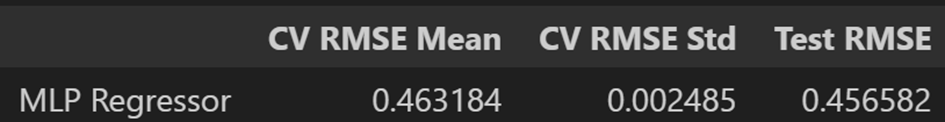
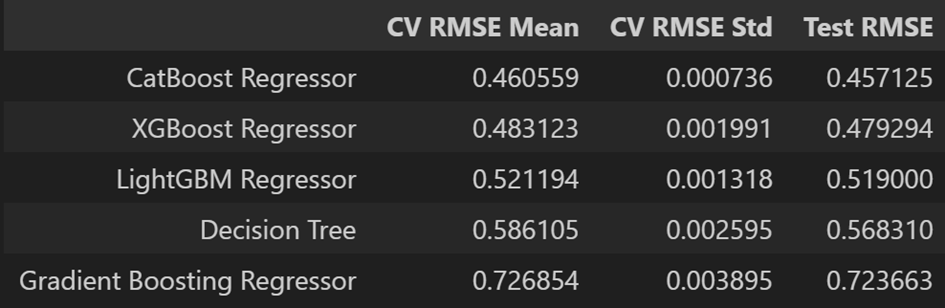
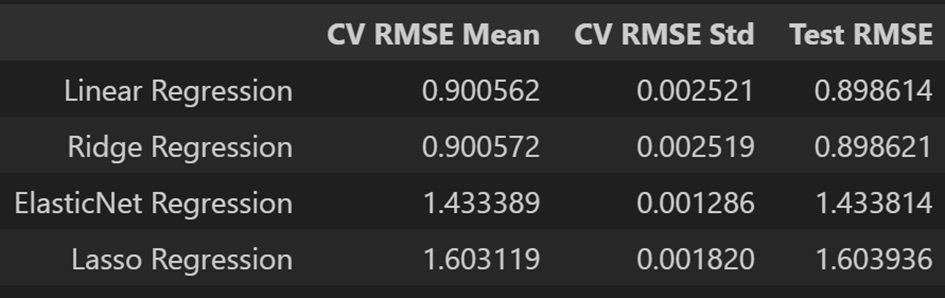


Considering theses results, we will try to fine-tune the hyperparameters of CatBoost Regressor, MLP Regressor and SGBoost Regressor

## Hyperparameters fine-tuning

Let's start with the CatBoost Regressor with the dataset without weather and covid data

In [ ]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0)
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 100, 500),  # Reduced range
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-5, 1e0, log=True),  # Reduced range
    "depth": lambda trial: trial.suggest_int('depth', 4, 8),  # Reduced range
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-8, 1e0, log=True),  # Reduced range
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-8, 1e0, log=True),  # Reduced range
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reduced range
    "border_count": lambda trial: trial.suggest_int('border_count', 32, 128),  # Reduced range
    "od_type": lambda trial: trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 10, 30)  # Reduced range
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.4  # Use 40% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('optuna_CatBoost_trials_sorted.csv', index=False)

In [16]:
CatBoost_optuna_results = pd.read_csv("optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_border_count,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_od_type,params_od_wait,params_random_strength,state
0,86,0.449193,2024-12-05 16:01:49.339279,2024-12-05 16:08:04.638402,0 days 00:06:15.299123,0.449999,115,8,469,0.077964,0.236029,IncToDec,26,1.046349e-09,COMPLETE
1,87,0.449369,2024-12-05 16:01:52.756593,2024-12-05 16:07:59.958669,0 days 00:06:07.202076,0.009273,125,8,473,0.081841,0.233748,IncToDec,24,4.590410e-09,COMPLETE
2,85,0.449609,2024-12-05 16:00:43.059179,2024-12-05 16:07:00.212031,0 days 00:06:17.152852,0.431026,55,8,461,0.078487,0.206682,IncToDec,24,1.077725e-09,COMPLETE
3,84,0.449609,2024-12-05 16:00:41.296392,2024-12-05 16:07:00.158900,0 days 00:06:18.862508,0.223811,52,8,469,0.038772,0.137107,IncToDec,24,1.375481e-09,COMPLETE
4,76,0.449632,2024-12-05 15:48:57.120001,2024-12-05 15:54:49.391462,0 days 00:05:52.271461,0.000075,123,8,460,0.031153,0.227992,IncToDec,20,1.017937e-09,COMPLETE


Let's now start tuning the hyperparameters with the CatBoost Regressor with the dataset weather and covid

In [ ]:
# Define the regressor and its hyperparameter search space
regressor_name = "CatBoost Regressor"
regressor = CatBoostRegressor(verbose=0)
hyperparams = {
    "iterations": lambda trial: trial.suggest_int('iterations', 100, 500),  # Reduced range
    "learning_rate": lambda trial: trial.suggest_float('learning_rate', 1e-5, 1e0, log=True),  # Reduced range
    "depth": lambda trial: trial.suggest_int('depth', 4, 8),  # Reduced range
    "l2_leaf_reg": lambda trial: trial.suggest_float('l2_leaf_reg', 1e-8, 1e0, log=True),  # Reduced range
    "bagging_temperature": lambda trial: trial.suggest_float('bagging_temperature', 1e-8, 1e0, log=True),  # Reduced range
    "random_strength": lambda trial: trial.suggest_float('random_strength', 1e-9, 10, log=True),  # Reduced range
    "border_count": lambda trial: trial.suggest_int('border_count', 32, 128),  # Reduced range
    "od_type": lambda trial: trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    "od_wait": lambda trial: trial.suggest_int('od_wait', 10, 30)  # Reduced range
}

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'  # Pass binary features as they are
)

# Train-test split
X = final_df[numeric_features + binary_features + categorical_features]
y = final_df['log_bike_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Use a smaller subset of the data for tuning
subset_size = 0.4  # Use 40% of the data
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=subset_size, random_state=1)

def objective(trial):
    model = regressor
    for param_name, param_func in hyperparams.items():
        model.set_params(**{param_name: param_func(trial)})

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    scores = cross_val_score(pipeline, X_train_subset, y_train_subset, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, n_jobs=-1)  # Use all available CPUs

# Best trial
best_trial = study.best_trial
best_params = {k: v for k, v in best_trial.params.items()}

print(f"Best model: {regressor_name}")
print(f"Best hyperparameters: {best_params}")
print(f"CV RMSE Mean: {best_trial.value}")

# Train the best model with the best hyperparameters
best_model = regressor
best_model.set_params(**best_params)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', best_model)
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

# Extract the trials and convert to DataFrame
trials_df = study.trials_dataframe()

# Sort the DataFrame by the objective value
trials_df_sorted = trials_df.sort_values(by='value')

# Display the sorted DataFrame
trials_df_sorted.head(20)

# Save the sorted DataFrame to a CSV file
trials_df_sorted.to_csv('global_optuna_CatBoost_trials_sorted.csv', index=False)

In [ ]:
CatBoost_optuna_results = pd.read_csv("global_optuna_CatBoost_trials_sorted.csv")
CatBoost_optuna_results.head()

In [ ]:
def prepare_data(df, weather_df, is_train=None):
    df = df.copy()

    df['date'] = pd.to_datetime(df['date']).dt.floor('h')
    weather_df['date'] = pd.to_datetime(weather_df['date']).dt.floor('h')
    df = pd.merge(df, weather_df, on='date', how='left')

    holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
    holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)
    holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
    df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5

    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])
    morning_rush = (df['hour'].between(7,9)) & df['is_working_day']
    evening_rush = (df['hour'].between(16,18)) & df['is_working_day']
    df['is_rush_hour'] = (morning_rush | evening_rush)

    cols_to_drop = ['counter_id', 'site_id', 'site_name', 'counter_installation_date',
                    'coordinates', 'counter_technical_id', 'hour', 'month', 'date']
    if 'bike_count' in df.columns:
        cols_to_drop.append('bike_count')

    df = df.drop(columns=cols_to_drop)

    if is_train:
        X = df.drop(columns=['log_bike_count'])
        y = df['log_bike_count']
        return X, y
    return df

def objective(trial, X_train_full, y_train_full):
    params = {
        'iterations': trial.suggest_int('iterations', 400, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),
        'depth': trial.suggest_int('depth', 6, 8),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.4, 0.9),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.05, 0.1),
        'border_count': trial.suggest_int('border_count', 100, 120),
        'od_type': 'IncToDec',
        'od_wait': trial.suggest_int('od_wait', 20, 30),
        'random_seed': 42
    }

    X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

    model = CatBoostRegressor(**params, cat_features=['counter_name', 'weekday'])
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50, verbose=False)

    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)

    return rmse

if __name__ == "__main__":
    train_df = pd.read_parquet(Path("data/train.parquet"))
    weather_df = pd.read_csv('external_data/Weather/Propre_meteo.csv')

    X_train, y_train = prepare_data(train_df, weather_df, is_train=True)

    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=20)

    print("\nBest parameters:", study.best_params)
    print("Best RMSE:", study.best_value)

    # Save best parameters
    pd.DataFrame([study.best_params]).to_json('best_params.json')

[I 2024-12-05 18:52:56,767] A new study created in memory with name: no-name-e7d45b1a-cac1-4262-a330-22693925ede8
c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-12-05 18:54:52,192] Trial 0 finished with value: 0.40650673825078404 and parameters: {'iterations': 488, 'learning_rate': 0.22220894170158145, 'depth': 7, 'bagging_temperature': 0.8306162353034621, 'l2_leaf_reg': 0.08798323178295492, 'border_count': 111, 'od_wait': 30}. Best is trial 0 with value: 0.40650673825078404.
c:\Users\alexa\Documents\Code Python et SQL\Python DSB\bike_counters_ac_team\.venv\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the r

KeyboardInterrupt: 